In [1]:
# Parameters
# Refer to injected parameters for any run.ipynb (similar cell below)
strain = 'BY4741'
locus = 'FKS1-HS1'

# Notebook to train a Gaussian mixture model

The model is trained on DMS data and used to predict the different classes of mutational effects

## Import libraries

In [2]:
import os
import pandas as pd
from sklearn.mixture import GaussianMixture
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'

## Specify paths

In [3]:
### Input
aggdata_outpath = '../../results/df/avg_scores.csv'
missing_mut_path = '../growth_data/validation_DMS_missing_estimates.csv'

### Output
classified_outpath = f'../classified/{"_".join([strain,locus])}/'
if not os.path.exists(classified_outpath):
    os.makedirs(classified_outpath)

graph_outpath = '../graphs/'
fungamr_outpath = '../fungamr/'

## Import data

In [4]:
master = pd.read_csv(aggdata_outpath).rename(columns={"Mutated_seq": "locus", "fitness_T2": "s", "lower_err_T2": "min_s", "upper_err_T2": "max_s"})
master

,strain,paralog,hotspot,locus,compound,Nham_aa,aa_seq,aa_pos,alt_aa,wt_aa,s,min_s,max_s
0,BY4741,FKS1,HS1,FKS1-HS1,none,0,FLVLSLRDP,not-applicable,not-applicable,not-applicable,-0.005178,0.004919,0.004919
1,BY4741,FKS1,HS1,FKS1-HS1,none,1,*LVLSLRDP,639,*,F,-0.364729,0.130043,0.130043
2,BY4741,FKS1,HS1,FKS1-HS1,none,1,ALVLSLRDP,639,A,F,-0.009024,0.069635,0.069635
3,BY4741,FKS1,HS1,FKS1-HS1,none,1,DLVLSLRDP,639,D,F,-0.031286,0.044307,0.044307
4,BY4741,FKS1,HS1,FKS1-HS1,none,1,ELVLSLRDP,639,E,F,0.029142,0.013222,0.013222
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,R1158,FKS2,HS2,FKS2-HS2,anidulafungin,1,SWVRRYTL,1372,S,D,-0.086795,0.162708,0.162708
3696,R1158,FKS2,HS2,FKS2-HS2,anidulafungin,1,TWVRRYTL,1372,T,D,0.106099,0.005660,0.005660
3697,R1158,FKS2,HS2,FKS2-HS2,anidulafungin,1,VWVRRYTL,1372,V,D,-0.169164,0.060304,0.060304
3698,R1158,FKS2,HS2,FKS2-HS2,anidulafungin,1,WWVRRYTL,1372,W,D,0.379459,0.056126,0.056126


## GMM

In [5]:
GMMdf = master[(master.strain == strain) & (master.locus == locus)
               ].groupby(["compound", "aa_seq"]
                         )[["s", "min_s", "max_s"]
                           ].agg(s = ("s", "first"),
                                 min_s = ("min_s", "first"),
                                 max_s = ("max_s", "first")
                                 ).reset_index()
GMMdf

,compound,aa_seq,s,min_s,max_s
0,anidulafungin,*LVLSLRDP,0.166788,0.125238,0.125238
1,anidulafungin,ALVLSLRDP,1.614675,0.112191,0.112191
2,anidulafungin,DLVLSLRDP,-0.044646,0.150571,0.150571
3,anidulafungin,ELVLSLRDP,0.564251,0.089555,0.089555
4,anidulafungin,F*VLSLRDP,0.134916,0.126564,0.126564
...,...,...,...,...,...
683,none,SLVLSLRDP,0.009320,0.012019,0.012019
684,none,TLVLSLRDP,-0.228853,0.073537,0.073537
685,none,VLVLSLRDP,0.028834,0.013133,0.013133
686,none,WLVLSLRDP,0.048208,0.010552,0.010552


### Optimize model

In [6]:
# Set specific seed
seed = 25 # Set value for repetability

# Initialize dictionary to store parameters for each condition
model_dict = {}

# Specify order of conditions
lcomp = ['none','dox','anidulafungin','caspofungin','micafungin']

# Optimize model for every condition (here, compound) separately
for j,c in enumerate(lcomp):
    if c in GMMdf.compound.unique():
        # The goal is to minimize AIC and BIC, but mostly BIC
        X = GMMdf[GMMdf.compound == c].s.values.reshape(-1,1)
        N = np.arange(1, 6)
        models = [None for i in range(len(N))] # testing up to 1-5 components
        # 5 is the max number of biologically relevant classes: deleterious, WT-like, intermediary, resistant, very resistant
        for i in range(len(N)):
            models[i] = GaussianMixture(n_components=N[i], random_state = seed).fit(X, y=None)

        # Compute AIC and BIC
        AIC = [m.aic(X) for m in models]
        BIC = [m.bic(X) for m in models]
    
        # Save parameters to dictionary
        model_dict[c.title()] = (N, AIC, BIC)

In [7]:
model_df = pd.DataFrame.from_dict(model_dict, orient='index', columns=['components','AIC','BIC']).reset_index(names='compound')
model_df = model_df.explode(['components','AIC','BIC']).melt(['compound','components'], var_name='IC')

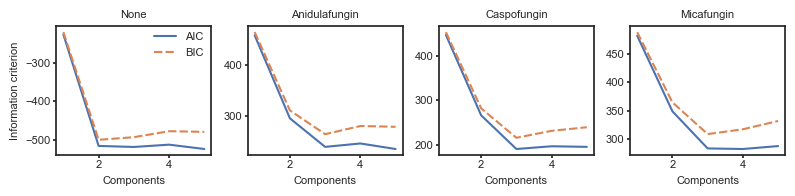

In [8]:
# Purge graph space
sns.set_theme(rc = {
              'font.family':'Arial',
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':2, 'ytick.major.pad':2,
              'xtick.bottom': True, 'ytick.left': True,
              'xtick.major.size':2, 'ytick.major.size':2,
             },
       style='ticks')

fig = sns.relplot(data=model_df, col='compound', x='components', y='value',
                  hue='IC', style='IC',
                  kind='line', height=2,
                  facet_kws = {'sharey':False, 'despine':False})

fig.set_titles(row_template='{row_name}', col_template='{col_name}')
fig.set_axis_labels('Components', 'Information criterion')
sns.move_legend(fig, 'upper left', bbox_to_anchor=(.175, .88), title=None)
plt.savefig(f'{graph_outpath}/{"_".join([strain,locus])}_GMM_BIC.svg', format='svg', dpi=300)

In [9]:
for c,y in model_dict.items(): # for each compound
    print(c, np.argmin(y[1])+1) # display the optimal number of components for the GMM

None 5
Anidulafungin 5
Caspofungin 3
Micafungin 4


### Run model

In [10]:
# Define the number of components (number of mods)
mods = 3

# Define range
mini = round(GMMdf.s.min()) - 1
maxi = round(GMMdf.s.max()) + 1

# Initialize list of df
proba_list = []

for i,c in enumerate(model_dict.keys()): # For every compound
    X = GMMdf[GMMdf.compound == c.lower()].s.values.reshape(-1,1)
    M_best = GaussianMixture(n_components=mods, random_state = seed).fit(X, y=None)
    GMMdf.loc[GMMdf.compound == c.lower(), 'label'] = M_best.predict(X)
    
    x = np.linspace(mini, maxi, len(GMMdf[GMMdf.compound == c.lower()]))
    logprob = M_best.score_samples(x.reshape(-1, 1))
    responsibilities = M_best.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    
    # Convert to dataframe
    indiv_df = pd.DataFrame(pdf_individual)
    indiv_df['x'] = x
    indiv_df = indiv_df.melt(id_vars = 'x', var_name = 'label', value_name='p(x)')
    indiv_df['compound'] = c
    proba_list.append(indiv_df)

proba_df = pd.concat(proba_list, ignore_index=True)
hist_df = GMMdf.copy()
hist_df['compound'] = hist_df.compound.apply(lambda x: x.title())

In [11]:
if os.path.exists(f'{classified_outpath}/thresholds.csv'):
    stddf = pd.read_csv(f'{classified_outpath}/thresholds.csv')
else:
    stddf = pd.DataFrame()
    print("Need to calculate thresholds. Will not display in next plot.")

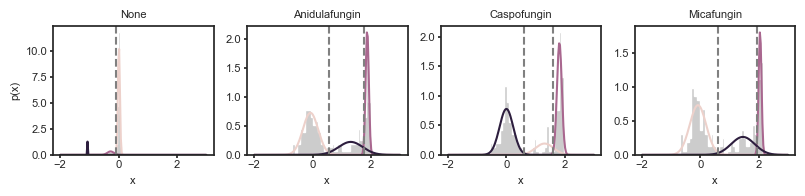

In [12]:
# Purge graph space
sns.set_theme(rc = {
              'font.family':'Arial',
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':2, 'ytick.major.pad':2,
              'xtick.bottom': True, 'ytick.left': True,
              'xtick.major.size':2, 'ytick.major.size':2,
             },
       style='ticks')

fig = sns.relplot(proba_df, col='compound',
                  x='x', y='p(x)', hue='label',
                  kind='line', height=2, legend=False,
                  facet_kws = {'sharey':False, 'despine':False}
                 )

fig.set_titles(row_template='{row_name}', col_template='{col_name}')

for i,c in enumerate(proba_df.compound.unique()):
    fig.axes[0][i].hist(hist_df[hist_df.compound == c].s,
                        30, density=True, histtype='stepfilled',
                        color='.8')
    if not stddf.empty:
        fig.axes[0][i].axvline(x=stddf[stddf.compound==c.lower()].val.tolist()[0], ls='--', color='grey')
        fig.axes[0][i].axvline(x=stddf[stddf.compound==c.lower()].val.tolist()[1], ls='--', color='grey')
    
plt.savefig(f'{graph_outpath}/{"_".join([strain,locus])}_GMM_densities.svg', format='svg', dpi=300)

In [13]:
# Looking at the predicted labels for each condition and the mean value to properly convert the label into a class
label_mean = GMMdf.groupby(['compound', 'label'])[['s']].agg(['size','mean']).reset_index().sort_values(by=[('compound',''),('s','mean')])
label_mean

compound label    s          
                        size      mean
0   anidulafungin   0.0   82 -0.072983
2   anidulafungin   2.0   38  1.288478
1   anidulafungin   1.0   52  1.875478
5     caspofungin   2.0   79 -0.000470
3     caspofungin   0.0   20  1.213283
4     caspofungin   1.0   73  1.803961
6      micafungin   0.0   88 -0.089084
8      micafungin   2.0   44  1.425358
7      micafungin   1.0   40  2.045599
11           none   2.0    1 -1.063235
10           none   1.0   15 -0.286382
9            none   0.0  156  0.008749

### Convert classification labels

In [14]:
class_dict = {}
class_list = ['WT-like', 'intermediary', 'resistant']
none_list = {'FKS1-HS1': ['deleterious', 'slightly deleterious', 'WT-like'],
             'FKS1-HS2': ['WT-like', 'WT-like', 'WT-like'],
             'FKS1-HS3': ['deleterious', 'slightly deleterious', 'WT-like'],
             'FKS2-HS1': ['slightly deleterious', 'WT-like', 'WT-like'],
             'FKS2-HS2': ['slightly deleterious', 'WT-like', 'WT-like']
            }
dox_list = {'FKS1-HS1': ['deleterious', 'slightly deleterious', 'WT-like'],
            'FKS2-HS1': ['deleterious', 'slightly deleterious', 'WT-like'],
            'FKS2-HS2': ['deleterious', 'slightly deleterious', 'WT-like']
           }

for c in label_mean.compound.unique():
    class_dict[c] = {}

i=0
for c,l in zip(label_mean.compound, label_mean.label):
    i = len(class_dict[c])
    if c in ['anidulafungin','caspofungin','micafungin']:
        class_dict[c][l] = class_list[i]
    elif c=='none':
        if locus in none_list.keys():
            class_dict[c][l] = none_list[locus][i]
        else:
            class_dict[c][l] = 'error'
    elif c=='dox':
        if locus in dox_list.keys():
            class_dict[c][l] = dox_list[locus][i]
        else:
            class_dict[c][l] = 'error'
    else:
        class_dict[c][l] = 'error'

class_dict

{'anidulafungin': {0.0: 'WT-like', 2.0: 'intermediary', 1.0: 'resistant'},
 'caspofungin': {2.0: 'WT-like', 0.0: 'intermediary', 1.0: 'resistant'},
 'micafungin': {0.0: 'WT-like', 2.0: 'intermediary', 1.0: 'resistant'},
 'none': {2.0: 'deleterious', 1.0: 'slightly deleterious', 0.0: 'WT-like'}}

In [15]:
GMMdf['rclass'] = GMMdf.apply(lambda row: class_dict[row.compound][row.label], axis=1)
GMMdf

,compound,aa_seq,s,min_s,max_s,label,rclass
0,anidulafungin,*LVLSLRDP,0.166788,0.125238,0.125238,0.0,WT-like
1,anidulafungin,ALVLSLRDP,1.614675,0.112191,0.112191,2.0,intermediary
2,anidulafungin,DLVLSLRDP,-0.044646,0.150571,0.150571,0.0,WT-like
3,anidulafungin,ELVLSLRDP,0.564251,0.089555,0.089555,2.0,intermediary
4,anidulafungin,F*VLSLRDP,0.134916,0.126564,0.126564,0.0,WT-like
...,...,...,...,...,...,...,...
683,none,SLVLSLRDP,0.009320,0.012019,0.012019,0.0,WT-like
684,none,TLVLSLRDP,-0.228853,0.073537,0.073537,1.0,slightly deleterious
685,none,VLVLSLRDP,0.028834,0.013133,0.013133,0.0,WT-like
686,none,WLVLSLRDP,0.048208,0.010552,0.010552,0.0,WT-like


In [16]:
GMMdf.to_csv(f'{classified_outpath}/raw_classification.csv')

## Breakdown: number of variants per class

In [17]:
GMMdf = pd.read_csv(f'{classified_outpath}/raw_classification.csv', index_col=0)

In [18]:
GMMdf.groupby(['compound', 'rclass'])[['s']].agg(['size','median'])

s          
                                   size    median
compound      rclass                             
anidulafungin WT-like                82 -0.088398
              intermediary           38  1.413885
              resistant              52  1.882616
caspofungin   WT-like                79 -0.002947
              intermediary           20  1.319337
              resistant              73  1.830777
micafungin    WT-like                88 -0.114466
              intermediary           44  1.461403
              resistant              40  2.050969
none          WT-like               156  0.009129
              deleterious             1 -1.063235
              slightly deleterious   15 -0.292238

## Refine classification (resolve overlaps)

To resolve overlaps , I use the distributions to define thresholds. However, because only the "resistant" and "WT-like" distributions (as called by the GMM) are narrow, we define the thresholds only for these groups. "Intermediary", "deleterious", etc end up being the label of variants which **did not** cross the thresholds.

### Step 1 - Set thresholds from narrow distributions

In [19]:
zthresh = 2.5 # set threshold in z-score

In [20]:
distri_params = GMMdf.groupby(['compound','rclass'])[['s']].agg(['mean','std']).reset_index()
distri_params.columns = [x[0] if x[1]=='' else x[1] for x in distri_params.columns]
distri_params['lower_bound'] = distri_params['mean'] - zthresh*distri_params['std']
distri_params['upper_bound'] = distri_params['mean'] + zthresh*distri_params['std']
distri_params

,compound,rclass,mean,std,lower_bound,upper_bound
0,anidulafungin,WT-like,-0.072983,0.257097,-0.715725,0.569759
1,anidulafungin,intermediary,1.288478,0.380094,0.338242,2.238714
2,anidulafungin,resistant,1.875478,0.049711,1.751199,1.999756
3,caspofungin,WT-like,-0.000470,0.237008,-0.592989,0.592049
4,caspofungin,intermediary,1.213283,0.245466,0.599619,1.826947
5,caspofungin,resistant,1.803961,0.088596,1.582471,2.025451
6,micafungin,WT-like,-0.089084,0.273760,-0.773484,0.595317
7,micafungin,intermediary,1.425358,0.383877,0.465665,2.385051
8,micafungin,resistant,2.045599,0.045249,1.932476,2.158722
9,none,WT-like,0.008749,0.034756,-0.078141,0.095639


In [21]:
stdlist = []

for c in distri_params.compound.unique():
    if c in ['caspofungin','micafungin','anidulafungin']:
        stdlist.append([c, 'low',
                        distri_params.loc[(distri_params.compound == c)
                                          & (distri_params.rclass == 'WT-like'),
                                          'upper_bound'
                                         ].values[0]
                       ])
        if locus in ['FKS1-HS1','FKS1-HS3','FKS2-HS1']:
            stdlist.append([c, 'up',
                            distri_params.loc[(distri_params.compound == c)
                                              & (distri_params.rclass == 'resistant'),
                                              'lower_bound'
                                             ].values[0]                    
                           ])
        elif locus in ['FKS1-HS2','FKS2-HS2']:
            stdlist.append([c, 'up',
                            distri_params.loc[(distri_params.compound == c)
                                              & (distri_params.rclass == 'intermediary'),
                                              'upper_bound'
                                             ].values[0]
                           ])
        else:
            print('Please define locus-specific bound')
    else:
        stdlist.append([c, 'low',
                        distri_params.loc[(distri_params.compound == c)
                                          & (distri_params.rclass == 'WT-like'),
                                          'lower_bound'
                                         ].values[0]
                       ])
        stdlist.append([c, 'up', None])
    
stddf = pd.DataFrame(stdlist, columns=['compound', 'thresh', 'val'])
stddf.to_csv(f'{classified_outpath}/thresholds.csv')
stddf

,compound,thresh,val
0,anidulafungin,low,0.569759
1,anidulafungin,up,1.751199
2,caspofungin,low,0.592049
3,caspofungin,up,1.582471
4,micafungin,low,0.595317
5,micafungin,up,1.932476
6,none,low,-0.078141
7,none,up,NaN


<Axes: xlabel='compound', ylabel='s'>

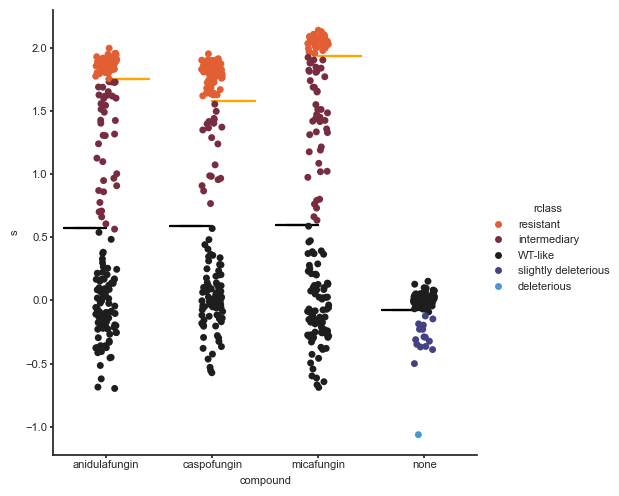

In [22]:
fig = sns.catplot(GMMdf, x='compound', y='s', hue='rclass',
            hue_order=['resistant','intermediary','WT-like','slightly deleterious','deleterious'],
            palette='icefire_r',
            #alpha=.3
                 )

sns.boxplot(stddf, x='compound', y='val',
            hue='thresh', hue_order=['low','up'], palette=['black','orange'], fill=False,
            legend=False)

### Step 2 - Refine classification

In [23]:
def refine_class(v, comp, threshdf):
    wtbound = threshdf.loc[(threshdf.compound == comp)
                           & (threshdf.thresh == 'low'),
                           'val'].values[0]
    resbound = threshdf.loc[(threshdf.compound == comp)
                           & (threshdf.thresh == 'up'),
                           'val'].values[0]
    
    if (comp in ['none','dox']) & (v > -.7):
        if (v >= wtbound):
            return 'WT-like'
        else:
            return 'slightly deleterious'
    elif (comp in ['none','dox']) & (v < -.7):
        return 'deleterious'
    else:        
        if v <= wtbound:
            return 'WT-like'
        elif v >= resbound:
            return 'resistant'
        else:
            return 'intermediary'

In [24]:
GMMdf['refined_class'] = GMMdf.apply(lambda row: refine_class(row.s, row.compound, stddf), axis=1)
GMMdf

,compound,aa_seq,s,min_s,max_s,label,rclass,refined_class
0,anidulafungin,*LVLSLRDP,0.166788,0.125238,0.125238,0.0,WT-like,WT-like
1,anidulafungin,ALVLSLRDP,1.614675,0.112191,0.112191,2.0,intermediary,intermediary
2,anidulafungin,DLVLSLRDP,-0.044646,0.150571,0.150571,0.0,WT-like,WT-like
3,anidulafungin,ELVLSLRDP,0.564251,0.089555,0.089555,2.0,intermediary,WT-like
4,anidulafungin,F*VLSLRDP,0.134916,0.126564,0.126564,0.0,WT-like,WT-like
...,...,...,...,...,...,...,...,...
683,none,SLVLSLRDP,0.009320,0.012019,0.012019,0.0,WT-like,WT-like
684,none,TLVLSLRDP,-0.228853,0.073537,0.073537,1.0,slightly deleterious,slightly deleterious
685,none,VLVLSLRDP,0.028834,0.013133,0.013133,0.0,WT-like,WT-like
686,none,WLVLSLRDP,0.048208,0.010552,0.010552,0.0,WT-like,WT-like


<Axes: xlabel='compound', ylabel='s'>

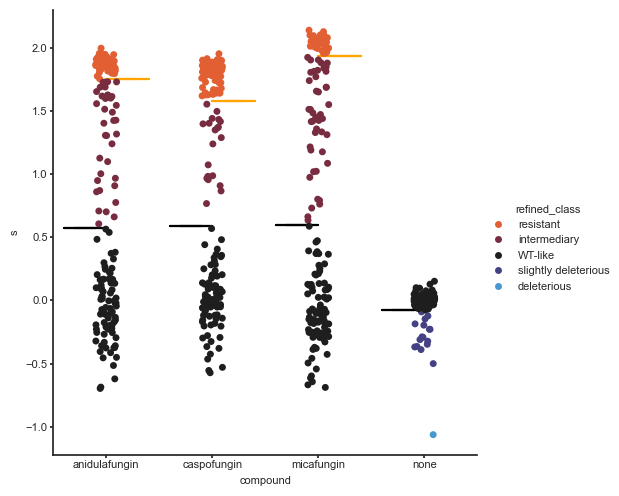

In [25]:
fig = sns.catplot(GMMdf, x='compound', y='s', hue='refined_class',
            hue_order=['resistant','intermediary','WT-like','slightly deleterious','deleterious'],
            palette='icefire_r',
            #alpha=.3
                 )

sns.boxplot(stddf, x='compound', y='val',
            hue='thresh', hue_order=['low','up'], palette=['black','orange'], fill=False,
            legend=False)

### Step 3 - Collapse classification (sensitive/resistant)

In [26]:
GMMdf['sensres'] = GMMdf.refined_class.replace({'intermediary':'resistant',
                                                'WT-like':'sensitive', 'slightly deleterious':'sensitive', 'deleterious':'deleterious'})
GMMdf

,compound,aa_seq,s,min_s,max_s,label,rclass,refined_class,sensres
0,anidulafungin,*LVLSLRDP,0.166788,0.125238,0.125238,0.0,WT-like,WT-like,sensitive
1,anidulafungin,ALVLSLRDP,1.614675,0.112191,0.112191,2.0,intermediary,intermediary,resistant
2,anidulafungin,DLVLSLRDP,-0.044646,0.150571,0.150571,0.0,WT-like,WT-like,sensitive
3,anidulafungin,ELVLSLRDP,0.564251,0.089555,0.089555,2.0,intermediary,WT-like,sensitive
4,anidulafungin,F*VLSLRDP,0.134916,0.126564,0.126564,0.0,WT-like,WT-like,sensitive
...,...,...,...,...,...,...,...,...,...
683,none,SLVLSLRDP,0.009320,0.012019,0.012019,0.0,WT-like,WT-like,sensitive
684,none,TLVLSLRDP,-0.228853,0.073537,0.073537,1.0,slightly deleterious,slightly deleterious,sensitive
685,none,VLVLSLRDP,0.028834,0.013133,0.013133,0.0,WT-like,WT-like,sensitive
686,none,WLVLSLRDP,0.048208,0.010552,0.010552,0.0,WT-like,WT-like,sensitive


In [27]:
GMMdf.to_csv(f'{classified_outpath}/refined_classification.csv')

### Step 4 - Compare with validations

At this stage, we need to perform a linear regression with growth data from reconstructed mutants, i.e. run [this notebook](./20240129_validations_test3.ipynb)